In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, pickle_model, corr

In [3]:
import warnings
warnings.simplefilter('ignore')

---
---
---
### Random back testing

In [6]:
df = fetch_data('goog_df')

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=1

In [7]:
np.random.seed(None)
env.seed(None)

In [8]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 932.2199710000001
action -1.0
total possible to sell 0
number sold 0.0
profit from selling 0.0
balance 1000000.0 shares held 0.0
previous net worth 1000000 current net worth 1000000.0

current price 937.080017
action 0.5
total possible to buy 1066.0786495044842
number bought 533.0393247522421
cost of buying 500000.0
balance 500000.0 shares held 533.0393247522421
previous net worth 1000000.0 current net worth 999500.4995004996

current price 943.0
action -0.25
total possible to sell 533.0393247522421
number sold 133.25983118806053
profit from selling 125538.35678953075
balance 625538.3567895307 shares held 399.7794935641816
previous net worth 999500.4995004996 current net worth 1002530.419220554

current price 919.6199949999999
action 0.25
total possible to buy 679.5344237226863
number bought 169.88360593067156
cost of buying 156384.58919738268
balance 469153.76759214804 shares held 569.6630994948532
previous net worth 1002530.419220554 current net worth 993027.3443012894


---

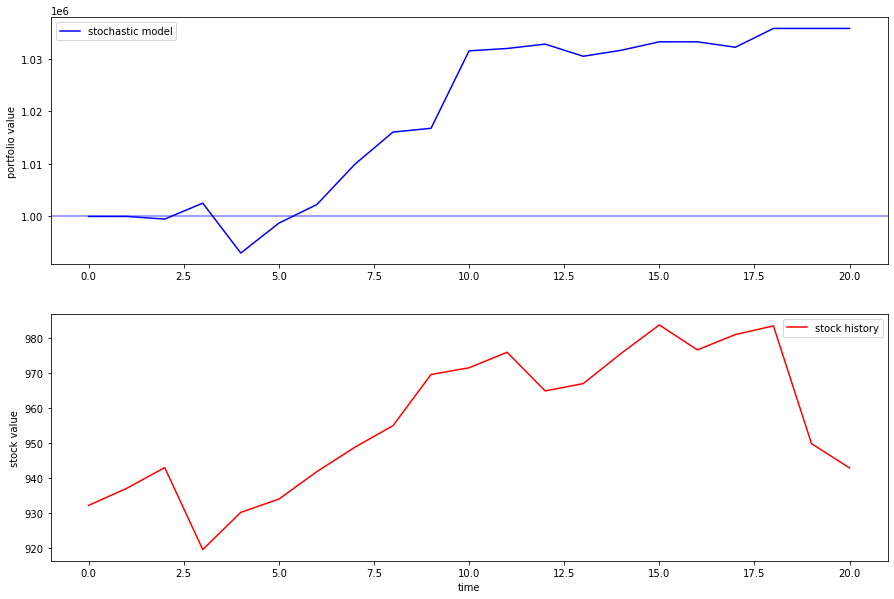

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(model_performance, 'b-', label='stochastic model')
ax1.set_ylabel('portfolio value')
ax1.axhline(starting_balance, alpha=0.5, color='blue')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

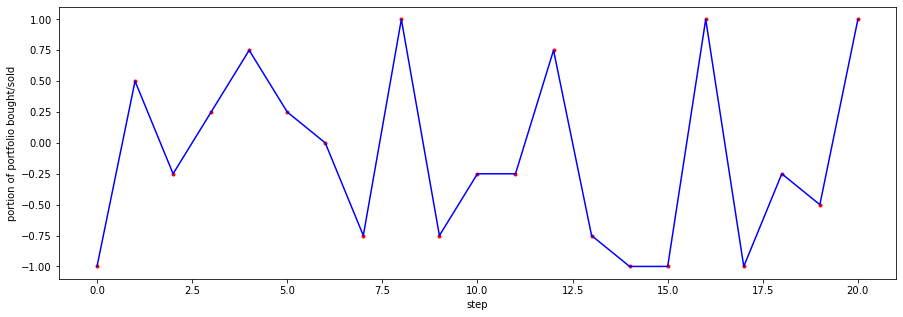

In [10]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'r.')
plt.plot(actions, 'b-')
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')

plt.show();

In [11]:
corr(actions, stock_performance)

0.34718631501058644

---
---
---
### Training/backtesting

In [13]:
df = fetch_data('goog_df')
#df.shape

In [14]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=0
env.seed(None)

#print(env.action_space, env.observation_space)

In [19]:
dqn_solver = DQN(
    action_space=env.action_space.n, 
    state_space=env.observation_space.shape,
    batch_size=64,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.999,
    alpha_min=0.1,
    gamma=0.99,
    )

dqn_solver.verbose = 0
#dqn_solver.model.summary()

In [20]:
history = []

In [ ]:
for i in np.arange(2500):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('FINAL PROFIT', env.net_worth-env.balance_init)
    print('TOTAL REWARD:', sum(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': sum(reward_trace),
        })

X, y = test

1
FINAL PROFIT -41652.841773006134
TOTAL REWARD: -35.642924397387915
DAY RANGE: 2095 2356
EXPLORATION: 1.0
MEMORY SIZE: 261




2
FINAL PROFIT 652.3592194482917
TOTAL REWARD: 0.08000079388405684
DAY RANGE: 1479 1496
EXPLORATION: 0.999
MEMORY SIZE: 278




3
FINAL PROFIT 17531.640339513542
TOTAL REWARD: 0.10134657208424783
DAY RANGE: 702 706
EXPLORATION: 0.998001
MEMORY SIZE: 282




4
FINAL PROFIT 44949.98053774249
TOTAL REWARD: -1.8461784482058625
DAY RANGE: 2245 2281
EXPLORATION: 0.997002999
MEMORY SIZE: 318




5
FINAL PROFIT -43270.786841189954
TOTAL REWARD: -0.07441338256503094
DAY RANGE: 1687 1701
EXPLORATION: 0.996005996001
MEMORY SIZE: 332




6
FINAL PROFIT -81650.09386163647
TOTAL REWARD: -13.029705694851076
DAY RANGE: 1907 2070
EXPLORATION: 0.995009990004999
MEMORY SIZE: 495




7
FINAL PROFIT 10790.72692004044
TOTAL REWARD: 0.05374327626303048
DAY RANGE: 1465 1472
EXPLORATION: 0.994014980014994
MEMORY SIZE: 502




8
FINAL PROFIT -9513.26323886204
TOTAL REWARD: -0.017481259





24
FINAL PROFIT 11286.76754557481
TOTAL REWARD: -2.822827208045809
DAY RANGE: 1338 1404
EXPLORATION: 0.9772512378214517
MEMORY SIZE: 1029




25
FINAL PROFIT -1900.525930533884
TOTAL REWARD: -1.0455446595751061
DAY RANGE: 1935 1988
EXPLORATION: 0.9762739865836303
MEMORY SIZE: 1082




26
FINAL PROFIT -10079.738932760083
TOTAL REWARD: 0.9303397434660967
DAY RANGE: 657 678
EXPLORATION: 0.9752977125970467
MEMORY SIZE: 1103




27
FINAL PROFIT -6683.638756653527
TOTAL REWARD: 0.09661838983416778
DAY RANGE: 1474 1487
EXPLORATION: 0.9743224148844496
MEMORY SIZE: 1116




28
FINAL PROFIT 10585.532563182176
TOTAL REWARD: -0.29284522908344046
DAY RANGE: 1169 1196
EXPLORATION: 0.9733480924695651
MEMORY SIZE: 1143




29
FINAL PROFIT -102443.3723080291
TOTAL REWARD: -2.0844072899385364
DAY RANGE: 1407 1460
EXPLORATION: 0.9723747443770956
MEMORY SIZE: 1196




30
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.007410067985701375
DAY RANGE: 1853 1857
EXPLORATION: 0.9714023696327185
MEMORY SIZE:





47
FINAL PROFIT -3414.345011582831
TOTAL REWARD: 0.10560566580957222
DAY RANGE: 884 894
EXPLORATION: 0.9550199818235596
MEMORY SIZE: 1994




48
FINAL PROFIT -30938.267370146466
TOTAL REWARD: -1.4153341604287348
DAY RANGE: 923 971
EXPLORATION: 0.9540649618417361
MEMORY SIZE: 2042




49
FINAL PROFIT 7389.230574084562
TOTAL REWARD: -0.6611785702930477
DAY RANGE: 2027 2070
EXPLORATION: 0.9531108968798944
MEMORY SIZE: 2085




50
FINAL PROFIT -60508.51741399511
TOTAL REWARD: -3.2293730859263965
DAY RANGE: 1182 1221
EXPLORATION: 0.9521577859830145
MEMORY SIZE: 2124




51
FINAL PROFIT -37696.52811967069
TOTAL REWARD: -0.004850210489468654
DAY RANGE: 959 978
EXPLORATION: 0.9512056281970315
MEMORY SIZE: 2143




52
FINAL PROFIT -24854.287429232616
TOTAL REWARD: -0.024611399665103995
DAY RANGE: 1838 1850
EXPLORATION: 0.9502544225688344
MEMORY SIZE: 2155




53
FINAL PROFIT 156877.42856429797
TOTAL REWARD: -25.068128707875896
DAY RANGE: 959 1152
EXPLORATION: 0.9493041681462656
MEMORY SIZE:





70
FINAL PROFIT -3294.8364188035484
TOTAL REWARD: 0.22149773754088337
DAY RANGE: 1839 1853
EXPLORATION: 0.933294459381294
MEMORY SIZE: 3287




71
FINAL PROFIT 7252.250002870336
TOTAL REWARD: -1.3117004216302364
DAY RANGE: 733 754
EXPLORATION: 0.9323611649219127
MEMORY SIZE: 3308




72
FINAL PROFIT 231418.1036328976
TOTAL REWARD: -1.8353374848253807
DAY RANGE: 137 221
EXPLORATION: 0.9314288037569908
MEMORY SIZE: 3392




73
FINAL PROFIT 80034.76668282971
TOTAL REWARD: 0.39653445909216184
DAY RANGE: 2334 2357
EXPLORATION: 0.9304973749532338
MEMORY SIZE: 3415




74
FINAL PROFIT 6414.440708351671
TOTAL REWARD: -0.031415496828123224
DAY RANGE: 604 608
EXPLORATION: 0.9295668775782806
MEMORY SIZE: 3419




75
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1047 1048
EXPLORATION: 0.9286373107007023
MEMORY SIZE: 3420




76
FINAL PROFIT 26660.871494644787
TOTAL REWARD: 0.0641821279660723
DAY RANGE: 2236 2246
EXPLORATION: 0.9277086733900016
MEMORY SIZE: 3430




77
FINAL PROF





93
FINAL PROFIT 3880.7391896649497
TOTAL REWARD: -0.039866356409118134
DAY RANGE: 792 841
EXPLORATION: 0.9120631656822724
MEMORY SIZE: 4348




94
FINAL PROFIT 64280.69816577714
TOTAL REWARD: -18.069740900909306
DAY RANGE: 1619 1752
EXPLORATION: 0.9111511025165902
MEMORY SIZE: 4481




95
FINAL PROFIT -76949.55043106573
TOTAL REWARD: 0.5453337989311862
DAY RANGE: 1432 1460
EXPLORATION: 0.9102399514140735
MEMORY SIZE: 4509




96
FINAL PROFIT -230.7188661058899
TOTAL REWARD: 0.9093997764370607
DAY RANGE: 261 277
EXPLORATION: 0.9093297114626595
MEMORY SIZE: 4525




97
FINAL PROFIT -26209.067330869264
TOTAL REWARD: 0.10480932195154398
DAY RANGE: 1505 1632
EXPLORATION: 0.9084203817511969
MEMORY SIZE: 4652




98
FINAL PROFIT -110074.0642729958
TOTAL REWARD: -0.875867354716705
DAY RANGE: 547 592
EXPLORATION: 0.9075119613694457
MEMORY SIZE: 4697




99
FINAL PROFIT 26911.753401958034
TOTAL REWARD: -0.4442821824551557
DAY RANGE: 627 637
EXPLORATION: 0.9066044494080763
MEMORY SIZE: 4707







116
FINAL PROFIT -3146.641565771657
TOTAL REWARD: -0.007824811016268552
DAY RANGE: 1571 1603
EXPLORATION: 0.8913148576343527
MEMORY SIZE: 5240




117
FINAL PROFIT 14805.133670995128
TOTAL REWARD: -0.0379367611566123
DAY RANGE: 226 244
EXPLORATION: 0.8904235427767183
MEMORY SIZE: 5258




118
FINAL PROFIT 16413.121554356767
TOTAL REWARD: -1.296068861627318
DAY RANGE: 2239 2278
EXPLORATION: 0.8895331192339416
MEMORY SIZE: 5297




119
FINAL PROFIT -7477.579966170946
TOTAL REWARD: 1.3392649103017784
DAY RANGE: 339 362
EXPLORATION: 0.8886435861147077
MEMORY SIZE: 5320




120
FINAL PROFIT 25820.527473155526
TOTAL REWARD: -31.15393438724274
DAY RANGE: 446 734
EXPLORATION: 0.887754942528593
MEMORY SIZE: 5608




121
FINAL PROFIT -77996.39999632363
TOTAL REWARD: -3.1514167182852106
DAY RANGE: 2287 2350
EXPLORATION: 0.8868671875860644
MEMORY SIZE: 5671




122
FINAL PROFIT -13145.140711934422
TOTAL REWARD: -0.3194762192675565
DAY RANGE: 1917 1972
EXPLORATION: 0.8859803203984784
MEMORY SIZ





139
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 833 834
EXPLORATION: 0.8710385479118223
MEMORY SIZE: 7092




140
FINAL PROFIT 48835.33576881327
TOTAL REWARD: -0.2834901462636507
DAY RANGE: 387 404
EXPLORATION: 0.8701675093639105
MEMORY SIZE: 7109




141
FINAL PROFIT 82257.33784092311
TOTAL REWARD: -18.5424086485615
DAY RANGE: 172 341
EXPLORATION: 0.8692973418545467
MEMORY SIZE: 7278




142
FINAL PROFIT 80619.68521639635
TOTAL REWARD: -11.032467483782742
DAY RANGE: 1205 1339
EXPLORATION: 0.8684280445126921
MEMORY SIZE: 7412




143
FINAL PROFIT -101357.85894101101
TOTAL REWARD: -33.455541834999266
DAY RANGE: 164 341
EXPLORATION: 0.8675596164681794
MEMORY SIZE: 7589




144
FINAL PROFIT -110891.63791999489
TOTAL REWARD: -23.420469320327097
DAY RANGE: 2172 2333
EXPLORATION: 0.8666920568517111
MEMORY SIZE: 7750




145
FINAL PROFIT 39523.532366227126
TOTAL REWARD: 3.4139605577769427
DAY RANGE: 822 982
EXPLORATION: 0.8658253647948594
MEMORY SIZE: 7910




146
FINAL P





162
FINAL PROFIT 6890.256854361505
TOTAL REWARD: -5.507166511960316
DAY RANGE: 2039 2122
EXPLORATION: 0.8512234991370281
MEMORY SIZE: 8737




163
FINAL PROFIT 110523.10505667282
TOTAL REWARD: -7.377270508372142
DAY RANGE: 1192 1274
EXPLORATION: 0.8503722756378911
MEMORY SIZE: 8819




164
FINAL PROFIT 26747.97834594664
TOTAL REWARD: -1.3721013492463274
DAY RANGE: 1228 1265
EXPLORATION: 0.8495219033622532
MEMORY SIZE: 8856




165
FINAL PROFIT -70885.74972205609
TOTAL REWARD: -0.8152614172956045
DAY RANGE: 1423 1487
EXPLORATION: 0.8486723814588909
MEMORY SIZE: 8920




166
FINAL PROFIT -98664.13382831775
TOTAL REWARD: -4.968390632862387
DAY RANGE: 1262 1462
EXPLORATION: 0.847823709077432
MEMORY SIZE: 9120




167
FINAL PROFIT -26998.224702905398
TOTAL REWARD: -14.258781572662896
DAY RANGE: 1051 1226
EXPLORATION: 0.8469758853683546
MEMORY SIZE: 9295




168
FINAL PROFIT 7430.926277046441
TOTAL REWARD: 0.3634206063895272
DAY RANGE: 1839 1853
EXPLORATION: 0.8461289094829862
MEMORY SIZ





185
FINAL PROFIT 37430.279602182796
TOTAL REWARD: -13.411963250315486
DAY RANGE: 423 508
EXPLORATION: 0.831859218194368
MEMORY SIZE: 10281




186
FINAL PROFIT 128040.83406383358
TOTAL REWARD: -1.162075099452364
DAY RANGE: 190 227
EXPLORATION: 0.8310273589761736
MEMORY SIZE: 10318




187
FINAL PROFIT 42988.12554542697
TOTAL REWARD: -3.1315281957908137
DAY RANGE: 1891 1959
EXPLORATION: 0.8301963316171974
MEMORY SIZE: 10386




188
FINAL PROFIT 16683.341355148354
TOTAL REWARD: -0.14858812995244938
DAY RANGE: 1582 1596
EXPLORATION: 0.8293661352855802
MEMORY SIZE: 10400




189
FINAL PROFIT 31201.01116665732
TOTAL REWARD: -0.05781374063782325
DAY RANGE: 556 562
EXPLORATION: 0.8285367691502946
MEMORY SIZE: 10406




190
FINAL PROFIT -90114.69406393869
TOTAL REWARD: -0.8647258786423033
DAY RANGE: 1737 1804
EXPLORATION: 0.8277082323811443
MEMORY SIZE: 10473




191
FINAL PROFIT 12285.924346215674
TOTAL REWARD: 0.0333864801019997
DAY RANGE: 1692 1706
EXPLORATION: 0.8268805241487632
MEMORY





208
FINAL PROFIT 24637.352958580712
TOTAL REWARD: -16.913968260320964
DAY RANGE: 1153 1320
EXPLORATION: 0.812935450673631
MEMORY SIZE: 11668




209
FINAL PROFIT -79143.8252598946
TOTAL REWARD: -0.22419215729122238
DAY RANGE: 2300 2327
EXPLORATION: 0.8121225152229574
MEMORY SIZE: 11695




210
FINAL PROFIT 93036.05935600214
TOTAL REWARD: 0.5255199586933015
DAY RANGE: 617 678
EXPLORATION: 0.8113103927077344
MEMORY SIZE: 11756




211
FINAL PROFIT -23947.353141975356
TOTAL REWARD: -0.6302431458898006
DAY RANGE: 1783 1844
EXPLORATION: 0.8104990823150267
MEMORY SIZE: 11817




212
FINAL PROFIT -59205.70639197086
TOTAL REWARD: 0.06572089121419573
DAY RANGE: 2116 2140
EXPLORATION: 0.8096885832327116
MEMORY SIZE: 11841




213
FINAL PROFIT 40513.83054352715
TOTAL REWARD: -0.16464163812234753
DAY RANGE: 495 515
EXPLORATION: 0.8088788946494789
MEMORY SIZE: 11861




214
FINAL PROFIT 134800.6208233668
TOTAL REWARD: -7.7761993944550545
DAY RANGE: 914 1084
EXPLORATION: 0.8080700157548294
MEMOR





231
FINAL PROFIT -48925.00440818095
TOTAL REWARD: -0.24705864271169123
DAY RANGE: 85 100
EXPLORATION: 0.7944421754397457
MEMORY SIZE: 13414




232
FINAL PROFIT -6800.648359823739
TOTAL REWARD: -2.04334642239753
DAY RANGE: 1697 1720
EXPLORATION: 0.7936477332643059
MEMORY SIZE: 13437




233
FINAL PROFIT -2441.373918962665
TOTAL REWARD: -0.054863622195589476
DAY RANGE: 392 434
EXPLORATION: 0.7928540855310416
MEMORY SIZE: 13479




234
FINAL PROFIT 398.29079362843186
TOTAL REWARD: -11.430559463239259
DAY RANGE: 962 1087
EXPLORATION: 0.7920612314455105
MEMORY SIZE: 13604




235
FINAL PROFIT 46003.84943631827
TOTAL REWARD: -2.711860852744096
DAY RANGE: 846 961
EXPLORATION: 0.7912691702140651
MEMORY SIZE: 13719


---

In [ ]:
i = -1

In [ ]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.yticks(np.arange(dqn_solver.action_space), np.linspace(-1,1, dqn_solver.action_space))
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [ ]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rewards, 'b-')
plt.xlabel('episode number')
plt.ylabel('total reward per episode')
plt.show();

In [ ]:
print(corr(history[i]['stock'], history[i]['actions']))

---

In [ ]:
pickle_model(dqn_solver, path='model_info_goog')

---
---
---
### Model testing

In [ ]:
env = TradingEnv(df, balance_init=1000, training=False)

In [ ]:
dqn_solver.alpha = 0
dqn_solver.alpha_min = 0
dqn_solver.is_fit = True
dqn_solver.replay();

In [ ]:
state = env.reset()

stock_performance = []
model_performance = []
reward_trace = []    
actions = []

start = env.current_step
done = False    

# The model will iterate until a terminal state is reached
while not done:

    # Select an action by passing the current observation/state to the DQN
    action = dqn_solver.act(state)

    # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
    next_state, reward, done, info = env.step(action)

    # Commit to the DQN's memory the relevant information
    dqn_solver.remember(state, action, reward, next_state, done)

    # Update the current state
    state = next_state

    actions.append(action)
    reward_trace.append(reward)
    model_performance.append(env.net_worth)  
    stock_performance.append(df.loc[env.current_step]['close'])

In [ ]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=stock_performance,
    fee=env.fee,
    )

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(model_performance, 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()